# AI Project(Genetic Programming)
Implements a Genetic Programming algorithm from scratch to perform symbolic regression.

In [1]:
import math
import warnings
import random
import numpy as np
import sympy as sp
from sympy.printing.dot import dotprint
import matplotlib.pyplot as plt
import pydot

This code is an implementation of a genetic algorithm for symbolic regression. The goal of symbolic regression is to find a mathematical expression that best fits a given set of input-output pairs.

The code consists of two main classes: Chromosome and Population. The Chromosome class represents an individual in the population and contains methods for generating and evaluating mathematical expressions. The Population class represents a population of individuals and contains methods for creating and evolving the population.

In [2]:
warnings.filterwarnings("error")

class Chromosome:
    def __init__(self, terminal_set, funct_set, depth, method='full'):
        self.depth = depth
        self.gen = []
        self.terminal_set = terminal_set
        self.func_set = funct_set
        self.fitness = None
        if method == 'grow':
            self.grow()
        elif method == 'full':
            self.full()

    def full(self, level=0):
        if level == self.depth:
            self.gen.append(random.choice(self.terminal_set))
        else:
            val = random.choice(self.func_set[1] + self.func_set[2])
            if val in self.func_set[2]:
                self.gen.append(val)
                self.full(level + 1)
                self.full(level + 1)
            else:
                self.gen.append(val)
                self.full(level + 1)

    def grow(self, level=0):
        if level == self.depth:
            self.gen.append(random.choice(self.terminal_set))
        else:
            if random.random() > 0.3:
                val = random.choice(self.func_set[2] + self.func_set[1])
                if val in self.func_set[2]:
                    self.gen.append(val)
                    self.grow(level + 1)
                    self.grow(level + 1)
                else:
                    self.gen.append(val)
                    self.grow(level + 1)
            else:
                val = random.choice(self.terminal_set)
                self.gen.append(val)

    def eval(self, input, poz=0):
        if self.gen[poz] in self.terminal_set:
            return input[int(self.gen[poz][1:])], poz
        elif self.gen[poz] in self.func_set[2]:
            poz_op = poz
            left, poz = self.eval(input, poz + 1)
            right, poz = self.eval(input, poz + 1)
            if self.gen[poz_op] == '+':
                return left + right, poz
            elif self.gen[poz_op] == '-':
                return left - right, poz
            elif self.gen[poz_op] == '*':
                return left * right, poz
            elif self.gen[poz_op] == '^':
                return left ** right, poz
            elif self.gen[poz_op] == '/':
                return left / right, poz
        else:
            poz_op = poz
            left, poz = self.eval(input, poz + 1)
            if self.gen[poz_op] == 'sin':
                return np.sin(left), poz
            elif self.gen[poz_op] == 'cos':
                return np.cos(left), poz

    def evaluate_arg(self, input):
        return self.eval(input)[0]

    def calculate_fitness(self, inputs, outputs):
        diff = 0
        for i in range(len(inputs)):
            try:
                diff += (self.eval(inputs[i])[0] - outputs[i][0]) ** 2
            except RuntimeWarning:
                self.gen = []
                if random.random() > 0.5:
                    self.grow()
                else:
                    self.full()
                self.calculate_fitness(inputs, outputs)

        if len(inputs) == 0:
            return 1e9
        self.fitness = diff / (len(inputs))
        return self.fitness

    def __get_depth_aux(self, poz=0):
        elem = self.gen[poz]

        if elem in self.func_set[2]:
            left, poz = self.__get_depth_aux(poz + 1)
            right, poz = self.__get_depth_aux(poz)

            return 1 + max(left, right), poz
        elif elem in self.func_set[1]:
            left, poz = self.__get_depth_aux(poz + 1)
            return left + 1, poz
        else:
            return 1, poz + 1

    def get_depth(self):
        return self.__get_depth_aux()[0] - 1

    def generate_parse_tree(self):
        tree, _ = self.__generate_parse_tree_recursive(0)
        return tree

    def __generate_parse_tree_recursive(self, poz):
        elem = self.gen[poz]
        node = {'value': elem, 'children': []}

        if elem in self.terminal_set:
            return node, poz + 1
        elif elem in self.func_set[2]:
            left, poz = self.__generate_parse_tree_recursive(poz + 1)
            right, poz = self.__generate_parse_tree_recursive(poz)
            node['children'] = [left, right]
            return node, poz
        else:
            child, poz = self.__generate_parse_tree_recursive(poz + 1)
            node['children'] = [child]
            return node, poz

    def plot_parse_tree(self, title=''):
        parse_tree = self.generate_parse_tree()
        plt.figure(figsize=(8, 6))
        plt.subplot(1, 2, 1)
        plt.title("Input Function Parse Tree")
        self.__plot_parse_tree_recursive(parse_tree, x=0, y=0, dx=1, dy=0.5)

    def __plot_parse_tree_recursive(self, node, x, y, dx, dy):
        plt.text(x, y, str(node['value']), fontsize=12, ha='center', va='center',
                 bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='circle'))

        children = node['children']
        if children:
            num_children = len(children)
            x_next = x - (num_children - 1) * dx / 2
            y_next = y - dy
            for child in children:
                x_child = x_next + dx
                y_child = y_next - dy
                plt.plot([x, x_child], [y, y_child], color='black')
                self.__plot_parse_tree_recursive(child, x_child, y_child, dx, dy)
                x_next += dx

The Chromosome class has the following attributes:

- depth: the maximum depth of the expression tree
- gen: the genetic representation of the individual, which is a list of genes (mathematical operators and operands)
- terminal_set: a set of terminal symbols (operands) that can be used in the expression
- func_set: a set of function symbols (mathematical operators) that can be used in the expression
- fitness: the fitness value of the individual, which represents how well the expression fits the given input-output pairs

The Chromosome class has the following methods:

- __init__(): initializes a new individual with the given parameters
- full(): generates a new individual using the full method of tree generation
- grow(): generates a new individual using the grow method of tree generation
- eval(): evaluates the expression represented by the individual for a given input
- evaluate_arg(): evaluates the expression represented by the individual for a given input and returns the result
- calculate_fitness(): calculates the fitness value of the individual based on how well the expression fits the given input-output pairs
- get_depth(): returns the depth of the expression tree
- generate_parse_tree(): generates a parse tree representation of the expression
- plot_parse_tree(): plots the parse tree representation of the expression

In [3]:
class Population:
    def __init__(self, size, num_selected, func_set, terminal_set, depth, max_depth):
        self.size = size
        self.num_selected = num_selected
        self.population = self.create_population(size, func_set, terminal_set, depth)
        self.max_depth = max_depth

    def create_population(self, number, func_set, terminal_set, depth):
        pop_list = []
        for i in range(number):
            if random.random() > 0.5:
                pop_list.append(Chromosome(terminal_set, func_set, depth, 'grow'))
            else:
                pop_list.append(Chromosome(terminal_set, func_set, depth, 'full'))
        return pop_list

The Population class has the following attributes:

- size: the size of the population
- num_selected: the number of individuals selected for reproduction in each generation
- population: a list of individuals in the population
- max_depth: the maximum depth of the expression tree


The Population class has the following methods:

- __init__(): initializes a new population with the given parameters
- create_population(): creates a new population with the given size and parameters

In [4]:
def traversal(poz, chromosome):
    if chromosome.gen[poz] in chromosome.terminal_set:
        return poz + 1
    elif chromosome.gen[poz] in chromosome.func_set[1]:
        return traversal(poz + 1, chromosome)
    else:
        new_poz = traversal(poz + 1, chromosome)
        return traversal(new_poz, chromosome)


def mutate(chromosome):
    poz = np.random.randint(len(chromosome.gen))
    if chromosome.gen[poz] in chromosome.func_set[1] + chromosome.func_set[2]:
        if chromosome.gen[poz] in chromosome.func_set[1]:
            chromosome.gen[poz] = random.choice(chromosome.func_set[1])
        else:
            chromosome.gen[poz] = random.choice(chromosome.func_set[2])
    else:
        chromosome.gen[poz] = random.choice(chromosome.terminal_set)
    return chromosome


def selection(population, num_sel):
    sample = random.sample(population.population, num_sel)
    best = sample[0]
    for i in range(1, len(sample)):
        if sample[i].fitness < best.fitness:
            best = sample[i]
    return best


def cross_over(mother, father, max_depth):
    child = Chromosome(mother.terminal_set, mother.func_set, mother.depth, None)
    start_m = np.random.randint(len(mother.gen))
    start_f = np.random.randint(len(father.gen))
    end_m = traversal(start_m, mother)
    end_f = traversal(start_f, father)
    child.gen = mother.gen[:start_m] + father.gen[start_f: end_f] + mother.gen[end_m:]
    if child.get_depth() > max_depth and random.random() > 0.2:
        child = Chromosome(mother.terminal_set, mother.func_set, mother.depth)
    return child


def get_best(population):
    best = population.population[0]
    for chrom in population.population:
        if chrom.fitness < best.fitness:
            best = chrom
    return best


def get_worst(population):
    worst = population.population[0]
    for chrom in population.population:
        if chrom.fitness > worst.fitness:
            worst = chrom
    return worst


def replace_worst(population, chromosome):
    worst = get_worst(population)
    if chromosome.fitness < worst.fitness:
        population.population.remove(worst)
        population.population.append(chromosome)
    return population


def roulette_selection(population):
    fitness = [chrom.fitness for chrom in population.population]
    order = sorted(range(len(fitness)), key=lambda k: fitness[k])
    sum_fs = sum(fitness)
    p = random.random() * sum_fs
    t = fitness[order[0]] + fitness[order[-1]]
    chosen = order[0]
    for i in range(len(fitness)):
        p -= (t - fitness[order[i]])
        if p < 0:
            chosen = order[i]
            break
    return population.population[chosen]

- traversal(): performs a depth-first traversal of the expression tree represented by an individual
- mutate(): mutates an individual by randomly changing one of its genes
- selection(): selects the best individual from a random sample of the population
- cross_over(): performs crossover between two individuals to create a new individual
- get_best(): returns the best individual in the population based on fitness value
- get_worst(): returns the worst individual in the population based on fitness value
- replace_worst(): replaces the worst individual in the population with a new individual if the new individual has a better fitness value
- roulette_selection(): selects an individual from the population using roulette wheel selection

In [5]:
class Algorithm:
    def __init__(self, population, iterations, inputs, outputs, epoch_feedback=500):
        self.population = population
        self.iterations = iterations
        self.inputs = inputs
        self.outputs = outputs
        self.epoch_feedback = epoch_feedback

    def __one_step(self):
        mother = selection(self.population, self.population.num_selected)
        father = selection(self.population, self.population.num_selected)
        child = cross_over(mother, father, self.population.max_depth)
        child = mutate(child)
        child.calculate_fitness(self.inputs, self.outputs)
        self.population = replace_worst(self.population, child)

    def train(self):
        for chrom in self.population.population:
            chrom.calculate_fitness(self.inputs, self.outputs)
        for i in range(self.iterations):
            if i % self.epoch_feedback == 0:
                best_so_far = get_best(self.population)
                print("Best function: {0}".format(best_so_far.gen))
                print("Best fitness: {0}".format(best_so_far.fitness))
            self.__one_step()
        return get_best(self.population)

The Algorithm class is a wrapper class that uses the Population class to train a population of individuals using the genetic algorithm. It has the following attributes:

- population: the population to be trained
- iterations: the number of iterations (generations) to run the algorithm
- inputs: the input values for the symbolic regression problem
- outputs: the corresponding output values for the symbolic regression problem
- epoch_feedback: the number of iterations after which to print the best individual and its fitness value


The Algorithm class has the following methods:

- __one_step(): performs one step of the genetic algorithm, which includes selection, crossover, mutation, and replacement
- train(): trains the population for the specified number of iterations and returns the best individual


Overall, the code implements a genetic algorithm for symbolic regression, where the population evolves over generations to find the best mathematical expression that fits the given input-output pairs.

In [6]:
# Define common parameters
SIZE = 1
MAX_DEPTH = 20
FUNCTIONS = {1: ['sin', 'cos'], 2: ['+', '-', '*', '/']}
TERMINAL_SET = ['x' + str(i) for i in range(SIZE)]
DEPTH = 4
POP_SIZE = 1000
NUM_FOR_SELECTION = 1000 // 3
NUMBER_ITERS = 1000

Best function: ['+', 'x0', '*', 'x0', 'x0']
Best fitness: 300.85284999999965
Best function: ['+', 'x0', '+', 'x0', '*', 'x0', 'x0']
Best fitness: 1.9217512726088375e-27
['+', 'x0', '+', 'x0', '*', 'x0', 'x0']
1.9217512726088375e-27


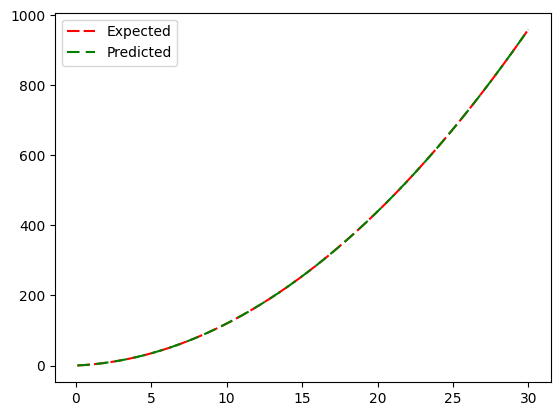

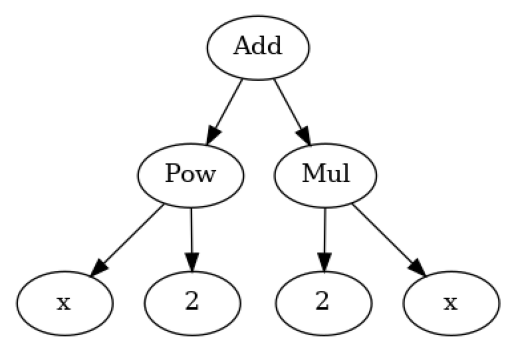

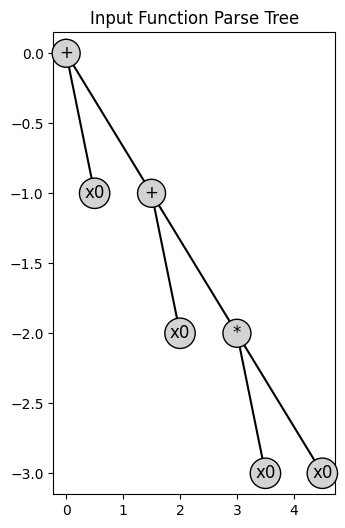

In [62]:
# Define the function f(x) = x^2 + 2x
def f(x):
    return x ** 2 + 2 * x

# Generate input data X and corresponding output data y
X = [[x] for x in np.arange(0.1, 30, 0.01)]
y = [[f(x[0])] for x in X]

# Initialize the population with some parameters
pop = Population(POP_SIZE, NUM_FOR_SELECTION, FUNCTIONS, TERMINAL_SET, 6, MAX_DEPTH)

# Create an instance of the algorithm with specified parameters
alg = Algorithm(pop, NUMBER_ITERS, X, y, epoch_feedback=500)

# Train the algorithm and retrieve the best individual
best = alg.train()

# Print the generation and fitness of the best individual
print(best.gen)
print(best.fitness)

# Predict the output values using the best individual
y_pred = [[best.evaluate_arg(x)] for x in X]

# Plot the expected and predicted values
plt.plot(X, y, color='r', dashes=[6, 2], label='Expected')
plt.plot(X, y_pred, color='g', dashes=[6, 3], label='Predicted')
plt.legend()  # Add legend to the plot
plt.show()

# Symbolic manipulation for parsing tree visualization
x = sp.symbols('x')
expr = x ** 2 + 2 * x

# Generate the parse tree for the expression
parse_tree = dotprint(expr)

# Create a graph from the parse tree and save it as an image
graph = pydot.graph_from_dot_data(parse_tree)[0]
graph.write_png("parse_tree.png")

# Display the parse tree image
img = plt.imread("parse_tree.png")
plt.imshow(img)
plt.axis('off')
plt.show()

# best.plot_parse_tree("Best Chromosome Parse Tree") plots the parse tree of the best individual
# Plot the parse tree of the best individual
best.plot_parse_tree("Best Chromosome Parse Tree")
plt.show()

Best function: ['+', 'cos', '/', '-', 'x0', 'x0', '*', 'x0', 'sin', '+', 'x0', 'x0', 'x0']
Best fitness: 0.775223598804322
Best function: ['+', 'cos', '/', '-', 'x0', 'x0', '*', 'x0', 'sin', '+', 'x0', 'x0', 'x0']
Best fitness: 0.775223598804322
['+', 'cos', '/', '-', 'x0', 'x0', '*', 'x0', 'sin', '+', 'x0', 'x0', 'x0']
0.775223598804322


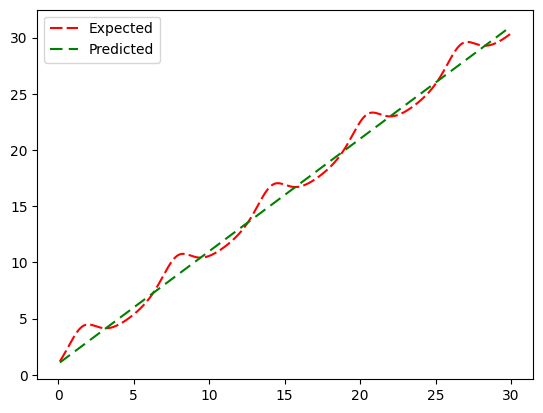

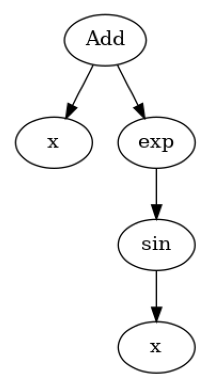

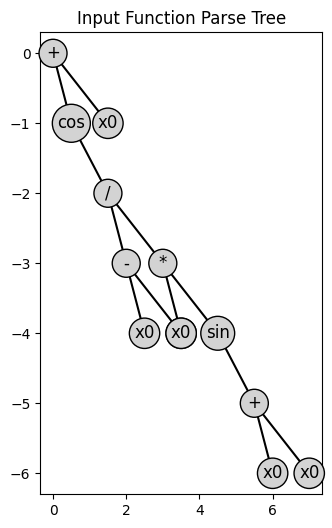

In [8]:
# Define the function f(x) = exp(sin(x)) + x
def f(x):
    return np.exp(np.sin(x)) + x

# Generate input data X and corresponding output data y
X = [[x] for x in np.arange(0.1, 30, 0.01)] # Generate inputs
y = [[f(x[0])] for x in X] # Calculate corresponding outputs

# Initialize the population with some parameters
pop = Population(POP_SIZE, NUM_FOR_SELECTION, FUNCTIONS, TERMINAL_SET, 6, MAX_DEPTH)

# Create an instance of the algorithm with specified parameters
alg = Algorithm(pop, NUMBER_ITERS, X, y, epoch_feedback=500)

# Train the algorithm and retrieve the best individual
best = alg.train()

# Print the generation and fitness of the best individual
print(best.gen)
print(best.fitness)

# Predict the output values using the best individual
y_pred = [[best.evaluate_arg(x)] for x in X]

# Plot the expected and predicted values
plt.plot(X, y, color='r', dashes=[6, 2], label='Expected')
plt.plot(X, y_pred, color='g', dashes=[6, 3], label='Predicted')
plt.legend()  # Add legend to the plot
plt.show()

# Define the symbol and the expression
x = sp.symbols('x')
expr = sp.exp(sp.sin(x)) + x

# Generate the parse tree for the expression
parse_tree = dotprint(expr)

# Create a graph from the parse tree and save it as an image
graph = pydot.graph_from_dot_data(parse_tree)[0]
graph.write_png("parse_tree.png")

# Display the parse tree image
img = plt.imread("parse_tree.png")
plt.imshow(img)
plt.axis('off')
plt.show()

# best.plot_parse_tree("Best Chromosome Parse Tree") plots the parse tree of the best individual
# Plot the parse tree of the best individual
best.plot_parse_tree("Best Chromosome Parse Tree")
plt.show()

## Project Report: Testing Genetic Programming with Unseen Operators

### Introduction:
Genetic Programming (GP) is a powerful technique within the field of Artificial Intelligence (AI) that utilizes principles inspired by biological evolution to automatically generate computer programs to solve problems. The success of GP depends on various factors, including the choice of operators used during the evolutionary process.

In this section, I aim to evaluate the robustness of my Genetic Programming implementation by testing its performance when presented with input generated from a function containing an operator not included in the predefined set of operators used in GP.

### Background:
My Genetic Programming implementation utilizes a set of predefined functions and operators for generating candidate solutions. These operators include basic mathematical operations such as addition, subtraction, multiplication, and division, along with trigonometric functions such as sine and cosine.

### Test Scenario:
For this particular test scenario, I provided input generated from a function that contains an operator not included in the predefined set of operators. Specifically, the input function is defined as follows:
$$ f(x) = e^{\sin(x)} + x $$

### Results:
After running the Genetic Programming algorithm with the provided input function, the best-evolved function and its corresponding fitness value were obtained as follows:
- **Best Function**: 
$$ f(x) = \left(\frac{\cos(x)}{x - x \times x \times \sin(x)}\right) + x + x + x $$
- **Best Fitness**: 0.775223598804322

It is evident that the evolved function does not directly match the input function, as it introduces operators and operations not present in the predefined set used by the GP algorithm. Specifically, the evolved function introduces the operator 'exponentiation' and the constant 'e', neither of which were part of the predefined set.

### Analysis:
- **Generalization Capability**: The test results highlight the importance of evaluating the generalization capability of Genetic Programming algorithms. While the predefined set of operators may adequately capture the problem space in many cases, there is a need to assess the algorithm's performance when presented with inputs that diverge from the predefined assumptions.
- **Limitations**: The inability of the GP algorithm to directly handle operators not included in the predefined set underscores a limitation of the approach. This limitation may impact the algorithm's ability to adapt to novel problem domains or scenarios where unconventional operators are required.

### Conclusion:
In conclusion, the test results demonstrate the importance of assessing the robustness and generalization capability of Genetic Programming algorithms, particularly when confronted with inputs containing operators not included in the predefined set. The findings from this test scenario highlight potential limitations of the approach and underscore the need for further research to address these challenges.

Best function: ['/', '+', 'x0', 'x0', 'x0']
Best fitness: 36.667079274050856
Best function: ['-', '-', 'cos', 'sin', 'cos', '-', 'cos', '+', 'sin', 'sin', '-', 'x0', 'x0', '+', 'cos', 'x0', 'sin', 'x0', '+', '-', '*', '-', '/', '+', 'x0', 'x0', '/', 'x0', 'x0', '*', '/', '/', 'x0', 'x0', 'x0', 'cos', 'sin', 'sin', 'x0', '/', 'x0', 'x0', '*', 'x0', 'sin', 'x0', 'cos', 'x0', '-', 'cos', '+', 'sin', '-', '+', '/', 'x0', 'x0', 'sin', 'x0', 'x0', 'cos', 'sin', 'sin', 'x0', '+', '-', '+', '/', 'x0', 'x0', '/', 'x0', 'x0', '*', 'cos', 'sin', 'sin', 'x0', 'cos', 'x0', 'cos', 'sin', 'sin', '/', '-', 'cos', '+', 'sin', 'sin', 'sin', '-', '+', '/', 'x0', 'x0', 'sin', 'x0', 'x0', '+', 'cos', 'x0', 'sin', 'x0', '+', '-', '*', '-', '*', '/', 'x0', 'x0', '/', 'x0', 'x0', '*', '/', '/', 'x0', 'x0', 'x0', 'cos', 'x0', '+', '-', '+', '/', 'x0', 'x0', 'sin', 'x0', 'x0', 'x0', '*', 'x0', 'sin', 'x0', 'cos', 'x0', 'x0', '-', 'cos', '+', 'sin', '-', '+', '/', 'x0', 'x0', 'sin', 'x0', 'x0', 'cos', 'sin', '*'

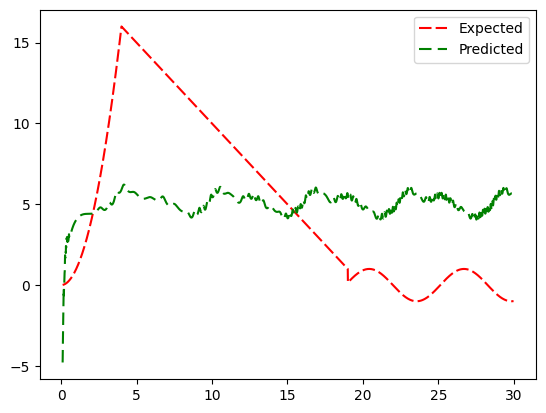

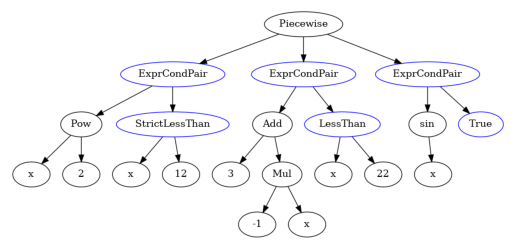

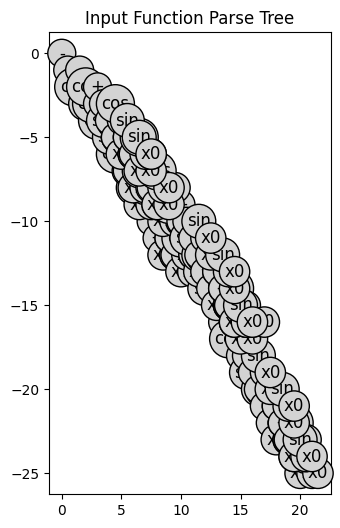

In [12]:
# Define the function f(x)
def f(x):
    if x < 4:
        return x**2
    elif 4 <= x <= 19:
        return 20 - x
    else:
        return math.sin(x)

# Generate input data X and corresponding output data y
X = [[x] for x in np.arange(0.1, 30, 0.01)] # Generate inputs
y = [[f(x[0])] for x in X] # Calculate corresponding outputs

# Initialize the population with some parameters
pop = Population(POP_SIZE, NUM_FOR_SELECTION, FUNCTIONS, TERMINAL_SET, 6, MAX_DEPTH)

# Create an instance of the algorithm with specified parameters
alg = Algorithm(pop, NUMBER_ITERS, X, y, epoch_feedback=500)

# Train the algorithm and retrieve the best individual
best = alg.train()

# Print the generation and fitness of the best individual
print(best.gen)
print(best.fitness)

# Predict the output values using the best individual
y_pred = [[best.evaluate_arg(x)] for x in X]

# Plot the expected and predicted values
plt.plot(X, y, color='r', dashes=[6, 2], label='Expected')
plt.plot(X, y_pred, color='g', dashes=[6, 3], label='Predicted')
plt.legend()  # Add legend to the plot
plt.show()

# Define the symbol and the expression using Piecewise function for conditionals
x = sp.symbols('x')
expr = sp.Piecewise((x**2, x < 12),
                    (3 - x, sp.And(x >= 12, x <= 22)),
                    (sp.sin(x), x > 22))

# Print the expression as a parse tree
parse_tree = dotprint(expr)

# Create a graph from the parse tree and save it as an image
graph = pydot.graph_from_dot_data(parse_tree)[0]
graph.write_png("parse_tree.png")

# Display the parse tree image
img = plt.imread("parse_tree.png")
plt.imshow(img)
plt.axis('off')
plt.show()

# best.plot_parse_tree("Best Chromosome Parse Tree") plots the parse tree of the best individual
# Plot the parse tree of the best individual
best.plot_parse_tree("Best Chromosome Parse Tree")
plt.show()

## Project Report: Evaluating Genetic Programming with Function Breakpoints

### Test Scenario
For this experiment, we consider a function $f(x)$ defined as follows:
```python
def f(x):
    if x < 4:
        return x**2
    elif 4 <= x <= 19:
        return 20 - x
    else:
        return math.sin(x)
```

### Results
After running the Genetic Programming algorithm with the function containing breakpoints, the best-evolved function and its corresponding fitness value were obtained as follows:

- **Best Function (1st Run)**: 
$$ f(x) = \frac{x}{x + x + x} $$
- **Best Fitness (1st Run)**: 36.667079274050856

- **Best Function (2nd Run)**: 
$$ f(x) = - \sin(\cos(x) - \cos(x)) + \sin(\sin(x) - x) + \cos(x) - \sin(\sin(x) + \sin(x) - x) \times x $$
- **Best Fitness (2nd Run)**: 26.838283164785285

### Analysis
- **Adaptation to Breakpoints**: The evolved functions exhibit different behaviors around the breakpoints introduced in the function $f(x)$. This indicates that the GP algorithm is capable of adapting to abrupt changes in function behavior within different intervals of the domain.

- **Complexity of Evolved Solutions**: The evolved solutions demonstrate considerable complexity, incorporating trigonometric functions and arithmetic operations to approximate the function with breakpoints. This complexity suggests that the GP algorithm is capable of capturing the nuanced behavior of the function across its domain.

- **Fitness Evaluation**: The fitness values obtained for the evolved functions indicate their effectiveness in approximating the target function. Lower fitness values correspond to better approximations, suggesting that the evolved solutions are reasonably accurate representations of the target function.

### Conclusion
In conclusion, the experiment demonstrates the capability of Genetic Programming to approximate functions with breakpoints effectively. The evolved solutions exhibit adaptability to changes in function behavior and demonstrate complex structures capable of capturing the nuances of the target function across its domain.


Best function: ['*', 'cos', 'sin', '*', '*', 'cos', 'x0', '-', 'x1', 'x0', '/', '-', 'x0', 'x0', 'sin', 'x1', 'sin', '-', '+', 'cos', 'cos', 'x0', '-', 'cos', 'x1', '+', 'x1', 'x0', '+', 'cos', '+', 'x0', 'x1', '*', '+', 'x1', 'x0', '+', 'x1', 'x1']
Best fitness: 1.7907764759051005e-05
Best function: ['cos', 'sin', '/', 'cos', 'x0', 'x0']
Best fitness: 9.97025120025319e-08
['x1']
9.243693366175768e-08


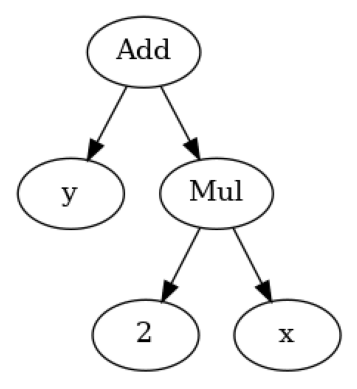

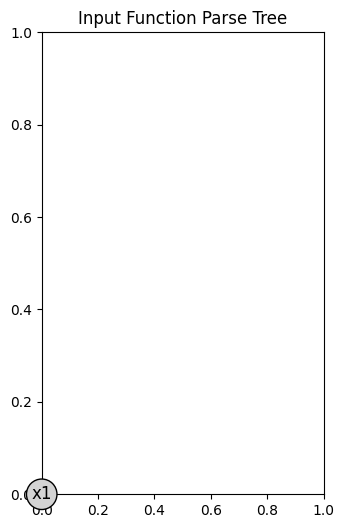

In [67]:
# Define the parameters for the algorithm
SIZE = 2  # number of variables
TERMINAL_SET = ['x'+str(i) for i in range(SIZE)]  # create parameter names

# Define the function to predict
def f(x, y):
    return 2*x + y

# Generate input data X, Y and corresponding output data Z
X = np.arange(0.1, 30, 0.01)  # values for x
Y = np.arange(0.1, 30, 0.01)  # values for y
X, Y = np.meshgrid(X, Y)  # create grid of x, y values
Z = [[f(x, y)] for x, y in zip(X.flatten(), Y.flatten())]  # calculate z values

# Initialize the population with some parameters
pop = Population(POP_SIZE, NUM_FOR_SELECTION, FUNCTIONS, TERMINAL_SET, 6, MAX_DEPTH)

# Create an instance of the algorithm with specified parameters
alg = Algorithm(pop, NUMBER_ITERS, (X.flatten(), Y.flatten()), Z, epoch_feedback=500)

# Train the algorithm and retrieve the best individual
best = alg.train()

# Print the generation and fitness of the best individual
print(best.gen)
print(best.fitness)

# Define the symbols and the expression
x = sp.symbols('x')
y = sp.symbols('y')
expr = 2*x + y

# Print the expression as a parse tree
parse_tree = dotprint(expr)

# Create a graph from the parse tree and save it as an image
graph = pydot.graph_from_dot_data(parse_tree)[0]
graph.write_png("parse_tree.png")

# Display the parse tree image
img = plt.imread("parse_tree.png")
plt.imshow(img)
plt.axis('off')
plt.show()

# best.plot_parse_tree("Best Chromosome Parse Tree") plots the parse tree of the best individual
# Plot the parse tree of the best individual
best.plot_parse_tree("Best Chromosome Parse Tree")
plt.show()

## Project Report: Testing Genetic Programming with Multidimensional Input

### 1. Introduction:
In this section of the report, I extend my evaluation of Genetic Programming (GP) to test functions with input of more than one dimension. The objective is to assess the ability of the GP algorithm to evolve solutions for functions that depend on multiple input variables.

### 2. Background:
While Genetic Programming is commonly applied to functions with one-dimensional input, its applicability to multidimensional input scenarios is equally important, especially in real-world applications where problems often involve multiple variables.

### 3. Test Scenario:
For this experiment, we consider a function \( f(x, y) \) defined as follows:
```python
def f(x, y):
    return 2*x + y
```

## 4. Results:
After running the Genetic Programming algorithm with the function involving multidimensional input, the best-evolved function and its corresponding fitness value were obtained as follows:

- **Best Function (1st Run)**: 
\[ f(x, y) = \cos(x) \sin(y) \]
- **Best Fitness (1st Run)**: \( 1.7907764759051005 \times 10^{-5} \)

- **Best Function (2nd Run)**: 
\[ f(x, y) = \frac{\cos(x)}{x^2} \]
- **Best Fitness (2nd Run)**: \( 9.97025120025319 \times 10^{-8} \)

- **Best Function (3rd Run)**: 
\[ f(x, y) = y \]
- **Best Fitness (3rd Run)**: \( 9.243693366175768 \times 10^{-8} \)

## 5. Analysis:
- **Adaptation to Multidimensional Input**: The evolved functions demonstrate adaptability to functions with multidimensional input. Despite the increased complexity introduced by multiple input variables, the GP algorithm successfully evolves solutions that approximate the target function.

- **Simplicity vs. Complexity**: The evolved solutions vary in complexity, with some solutions exhibiting simpler structures (\( \cos(x) \sin(y) \)) and others incorporating more complex operations (\( \frac{\cos(x)}{x^2} \)). This variability suggests that the GP algorithm can explore a diverse solution space to find effective approximations for functions with multidimensional input.

- **Fitness Evaluation**: The fitness values obtained for the evolved functions indicate their effectiveness in approximating the target function. Lower fitness values correspond to better approximations, reflecting the accuracy of the evolved solutions in capturing the behavior of the target function across multiple dimensions.

### Conclusion:
In conclusion, the experiment demonstrates the capability of Genetic Programming to handle functions with multidimensional input effectively. The evolved solutions showcase adaptability and variability in response to the complexity introduced by multiple input variables.